2191
1194
Let's use 4 GPUs!


/home/laly/alligator/local/lib/python3.5/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/laly/alligator/local/lib/python3.5/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1,   137] loss: 16.705
[1,    75] loss: 17.066
[2,   137] loss: 16.470
[2,    75] loss: 17.000
[3,   137] loss: 16.175
[3,    75] loss: 16.727
[4,   137] loss: 15.621
[4,    75] loss: 15.994
[5,   137] loss: 14.772
[5,    75] loss: 14.989
[6,   137] loss: 14.241
[6,    75] loss: 15.167
[7,   137] loss: 13.782
[7,    75] loss: 14.353
[8,   137] loss: 13.608
[8,    75] loss: 14.791
[9,   137] loss: 13.459
[9,    75] loss: 14.435
[10,   137] loss: 13.244
[10,    75] loss: 14.022
[11,   137] loss: 13.115
[11,    75] loss: 13.768
[12,   137] loss: 13.039
[12,    75] loss: 14.044
[13,   137] loss: 12.744
[13,    75] loss: 13.897
[14,   137] loss: 12.737
[14,    75] loss: 13.637
[15,   137] loss: 12.706
[15,    75] loss: 13.642
[16,   137] loss: 12.607
[16,    75] loss: 13.842
[17,   137] loss: 12.540
[17,    75] loss: 13.520
[18,   137] loss: 12.512
[18,    75] loss: 13.512
[19,   137] loss: 12.401
[19,    75] loss: 13.525
[20,   137] loss: 12.383
[20,    75] loss: 13.458
[21,   137] loss: 

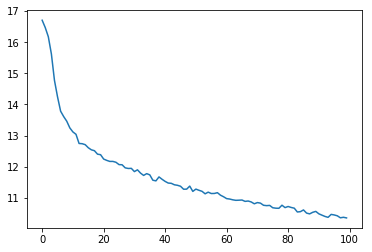

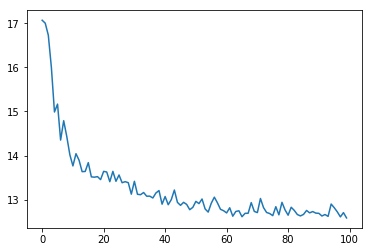

Finis !


In [2]:
from pydub import AudioSegment
from scipy import signal
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from pydub import playback
from pydub import generators
import array
import time
import musdb
from torch.utils import data
import Dataset
import Net



device = torch.device("cuda:0") #Select the GPU we want to use
mus = musdb.DB(root_dir="/mnt/scratch/lts2/laly/musdb") #Folder containing the testing and training songs



######################################################################################################################



global list_Sxx_input_train 
global list_Sxx_vocal_train 

list_Sxx_input_train = []   #List that will contain the real and imaginary part of the spectrograms of the training songs
list_Sxx_vocal_train = []   #List that will contain the real and imaginary part of the spectrograms of the vocals, bass, drums of the training songs

def training_Dataset_Generation(track, list_Sxx_input_train=list_Sxx_input_train, list_Sxx_vocal_train=list_Sxx_vocal_train):
    l = len(track.audio)
    track_a = np.array(track.audio)  #The songs in the dataset are in format mp4
    track_b = np.array(track.targets['vocals'].audio)
    track_c = np.array(track.targets['drums'].audio)
    track_d = np.array(track.targets['bass'].audio)

    fs = 44100/5
    
    track_i = (track_a[:,0]+track_a[:,1])/2   #The songs from the dataset are stereo, we compute them in mono
    track_v = (track_b[:,0]+track_b[:,1])/2
    track_dr = (track_c[:,0]+track_c[:,1])/2
    track_ba = (track_d[:,0]+track_d[:,1])/2
    
    track_i = signal.decimate(track_i,5)   #Downsampling to 8,8 kHz in frequency samples to accelerate the training phase
    track_v = signal.decimate(track_v,5)
    track_d = signal.decimate(track_dr,5)
    track_b = signal.decimate(track_ba,5)
    
    f, t, Sxx = signal.stft(track_v, fs, 'hamming',2048,1024,2048)   #Short Time Fourier Transform, the output are complex spectrograms of the whole song
    f, t, Sxx_noised = signal.stft(track_i, fs, 'hamming',2048,1024,2048)
    f, t, Sxx_d = signal.stft(track_d, fs, 'hamming',2048,1024,2048)
    f, t, Sxx_b = signal.stft(track_b, fs, 'hamming',2048,1024,2048)
    
    Sxx_real_noised = np.real(Sxx_noised)*100000 #Gain to improve the loss function and the learning phase. We could have use the gain on the learning rate
    Sxx_imag_noised = np.imag(Sxx_noised)*100000#We separate real and imaginary part, both spectrograms will be the input of the neural network
    Sxx_real = np.real(Sxx)*100000
    Sxx_imag = np.imag(Sxx)*100000
    Sxx_real_d = np.real(Sxx_d)*100000
    Sxx_imag_d = np.imag(Sxx_d)*100000
    Sxx_real_b = np.real(Sxx_b)*100000
    Sxx_imag_b = np.imag(Sxx_b)*100000
    
    for i in range(0,len(Sxx_real[0]),88): #We cut the spectrograms in order to be the size of 1025x88, it means that we have 1025 points in frequency (from 0 Hz to 4,4 kHz) and 88 points in time (it represents 2 second of the song)
        
        Sxx_real_i = Sxx_real[:,i:i+88]
        Sxx_imag_i = Sxx_imag[:,i:i+88]
        Sxx_real_noised_i = Sxx_real_noised[:,i:i+88]
        Sxx_imag_noised_i = Sxx_imag_noised[:,i:i+88]
        Sxx_real_dr = Sxx_real_d[:,i:i+88]
        Sxx_imag_dr = Sxx_imag_d[:,i:i+88]
        Sxx_real_ba = Sxx_real_b[:,i:i+88]
        Sxx_imag_ba = Sxx_imag_b[:,i:i+88]
        
        if len(Sxx_real_i[1]) == 88:
            list_Sxx_vocal_train += [[Sxx_real_i,Sxx_imag_i,Sxx_real_dr,Sxx_imag_dr,Sxx_real_ba,Sxx_imag_ba]]
            list_Sxx_input_train += [[Sxx_real_noised_i,Sxx_imag_noised_i]]   
 
            
      
###################################################################################################################



mus.run(training_Dataset_Generation, subsets="train", estimates_dir=None)



###################################################################################################################
    
    
    
training_set = Dataset(list_Sxx_input_train, list_Sxx_vocal_train)  #Create the spectrogram Dataset from the lists

trainloader = torch.utils.data.DataLoader(training_set, batch_size=16,shuffle=True, num_workers=0)   #Create random batch of size 16 in order to improve the learning of the network.

#net = torch.load('DANN.pt')  #Load an existing network
net = Net()                   #Create a new network

if torch.cuda.device_count() > 1:  #If you want to use many GPUSs
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  net = nn.DataParallel(net)

net.to(device)

criterion = nn.L1Loss()   #Doesn't over exaggerate the "big" mistakes and minimize the "small" mistakes as the MSELoss
criterion_GPU = criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader,0):
        inputs, vocals = data
        inputs_GPU = inputs.to(device)
        vocals_GPU = vocals.to(device)
        
        inputs_GPU_cat = torch.cat((inputs_GPU,inputs_GPU,inputs_GPU),1)
        
        optimizer.zero_grad()
        mask = net(inputs_GPU)
        outputs_GPU = mask * inputs_GPU_cat
        loss = criterion(outputs_GPU, vocals_GPU)
        loss.backward()
        optimizer.step()
        
        torch.save(net,'DANN.pt')
        
        running_loss += loss.item()
        
        if i + 1 == 100:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    